In [63]:
# python2.7
import csv
import numpy as np
import numpy.linalg as linalg
from scipy.optimize import linprog
import matplotlib.pyplot as plt

In [64]:
def mse(w, Xt, y):
    mse_h = 0
    for xi, yi in zip(Xt, y):
        mse_h += (np.dot(w, xi) - yi) ** 2
    return mse_h / len(Xt)

Implementation without SVD.

In [65]:
def ridge(X, Xt, y, tau):
    I = np.identity(d)
    
    XXt = np.dot(X, Xt)
    XXt_tauI = XXt + tau * I
    XXt_tauI_inv = linalg.inv(XXt_tauI)
    Xy = np.dot(X, y)
    return np.dot(XXt_tauI_inv, Xy)

Implementation with SVD.

In [66]:
U = None
D = None
Vt = None
def ridge_svd(tau, y):
    global U, D, Vt
    if U is None:
        U, D, Vt = linalg.svd(X)
    Dt = np.zeros(shape=(len(X[0]), len(X))) # (m, d)
    for i, d in enumerate(D):
        Dt[i, i] = (d ** 2 + tau) ** 0.5
    Dt_pinv = linalg.pinv(Dt)
    U_Dt_pinv = np.dot(U, Dt_pinv)
    U_Dt_pinv_Vt = np.dot(U_Dt_pinv, Vt)
    return np.dot(U_Dt_pinv_Vt, y)

Run ridge regression multiple times for different $\tau$ and draw a plot how MSE depends on $\tau$.

In [67]:
def plot_tau(y):
    plt.figure(figsize=(14, 5))
    
    tau_values = [x / 10.0 for x in xrange(0, 1001)]
    w_values = [ridge_svd(tau, y) for tau in tau_values]
    mse_values = [mse(w, Xt, y) for w in w_values]
    
    plt.plot(tau_values, mse_values)
    plt.xlabel('tau')
    plt.ylabel('MSE')
    
    plt.show()

In [68]:
players = np.genfromtxt('data/basketball.csv', delimiter=',', skip_header=1)

Prepare size of training set, number of features, features themselves, labels.

Adding '1's to each element's feature vector to reflect bias.

In [69]:
m = len(players)
d = len(players[0]) # len(players[0]) - 1 + 1 for 'b'

Xt = np.array([np.append(player[:4], 1) for player in players])
X = np.transpose(Xt)
y = np.array([player[4] for player in players])

Ridge regression.

Ridge regression without SVD.
w (last element is for bias): [-3.69049908e+00  9.45845788e-03  4.79401992e+01  1.13710193e+01
  4.14870671e+00]
MSE: 26.5654032851
Ridge regression with SVD.
w (last element is for bias): [-3.69049908e+00  9.45845788e-03  4.79401992e+01  1.13710193e+01
  4.14870671e+00]
MSE: 26.5654032851


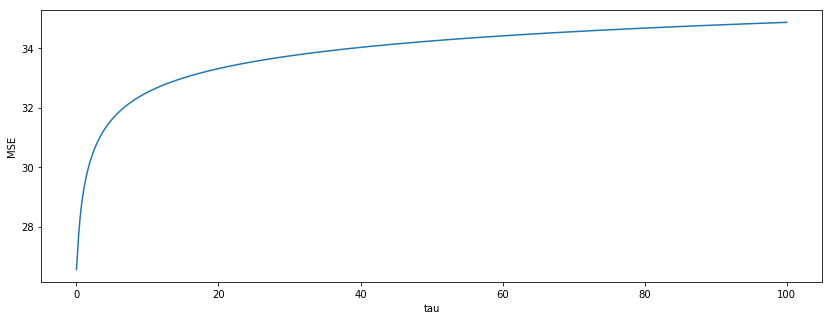

In [70]:
def task1():
    # the best found tau
    tau = 0
    
    w = ridge(X, Xt, y, tau)
    print 'Ridge regression without SVD.'
    print 'w (last element is for bias): {}'.format(w)

    mse_h = mse(w, Xt, y)
    print 'MSE: {}'.format(mse_h)

    w = ridge_svd(tau, y)
    print 'Ridge regression with SVD.'
    print 'w (last element is for bias): {}'.format(w)

    mse_h = mse(w, Xt, y)
    print 'MSE: {}'.format(mse_h)

    plot_tau(y)

task1()

In [71]:
def mae(w, Xt, y):
    mae_h = 0
    for xi, yi in zip(Xt, y):
        mae_h += np.abs(np.dot(w, xi) - yi)
    return mae_h / len(Xt)

In [72]:
def least_absolute_regression(Xt, y):
    m = len(Xt)
    d = len(Xt[0])
    
    A = np.block([
            [np.eye(m) * -1, Xt],
            [np.eye(m) * -1, Xt * -1]
        ])
    b = np.block([y, y * -1])
    c = np.block([np.ones(m), np.zeros(d)])
    
    optimize_result = linprog(c, A, b)
    
    return optimize_result.x[-d:]

Least absolute regression

In [73]:
def task2():
    w = least_absolute_regression(Xt, y)
    print 'Least absolute regression.'
    print 'w (last element is for bias): {}'.format(w)
    
    mae_h = mae(w, Xt, y)
    print 'MAE: {}'.format(mae_h)

task2()

Least absolute regression.
w (last element is for bias): [ 0.         0.         5.3720284 10.9138623  0.       ]
MAE: 4.10147850846


Выборка имеет довольно сильные выбросы, которые в случае MSE дают большую величину ошибки, чем для MAE, т.к. возводятся в квадрат. Поэтому значение MAE на данной выборке существенно лучше: 4 против 26.

Можно сделать вывод, что оптимизацию MSE лучше выбирать, когда необходимо минимизировать силу выбросов, тогда как MAE - когда необходима оптимизация в среднем и можно позволить небольшое количество сильных выбросов.